<a href="https://colab.research.google.com/github/wagner1986/PapyrusTech/blob/main/LocalFeatureMatcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kornia
!pip install kornia_moons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 4.2 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torchvision
import kornia as K

class PreprocessPipeline(nn.Module):
    def __init__(self):
        super(PreprocessPipeline, self).__init__()
        self.transforms = nn.Sequential(
            # Normaliza a imagem para ter valores no intervalo [0, 1]
            K.enhance.Normalize(0.0, 255.0),
            # Redimensiona a imagem para o tamanho desejado
            K.geometry.Resize((320, 240)),
            # Converte a imagem RGB para escala de cinza
            K.color.RgbToGrayscale(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Normaliza a imagem para ter valores no intervalo [0, 1]
        x = x.float() / 255.0  # Garante que a operação de divisão é realizada em float
        # Aplica as transformações definidas em __init__
        x = self.transforms(x)
        # Adiciona uma dimensão de batch no início se ainda não houver
        if x.ndim == 3:
            x = x.unsqueeze(0)
        return x

# Inicializa o pipeline de preprocessamento
preprocess = PreprocessPipeline()


In [31]:
from kornia.feature import LocalFeatureMatcher,GFTTAffNetHardNet

# Carregar as duas imagens utilizando torchvision
img1 = torchvision.io.read_image("image1.jpg").float() / 255.0
img2 = torchvision.io.read_image("image2.jpg").float() / 255.0

# Aplica o pipeline de preprocessamento à imagem
img1_preprocessed = preprocess(img1)
# Aplica o pipeline de preprocessamento à imagem
img2_preprocessed = preprocess(img2)


input = {"image0": img1_preprocessed, "image1": img2_preprocessed}
gftt_hardnet_matcher = LocalFeatureMatcher(
    GFTTAffNetHardNet(30), K.feature.DescriptorMatcher('snn', 0.9)
)
out = gftt_hardnet_matcher(input)

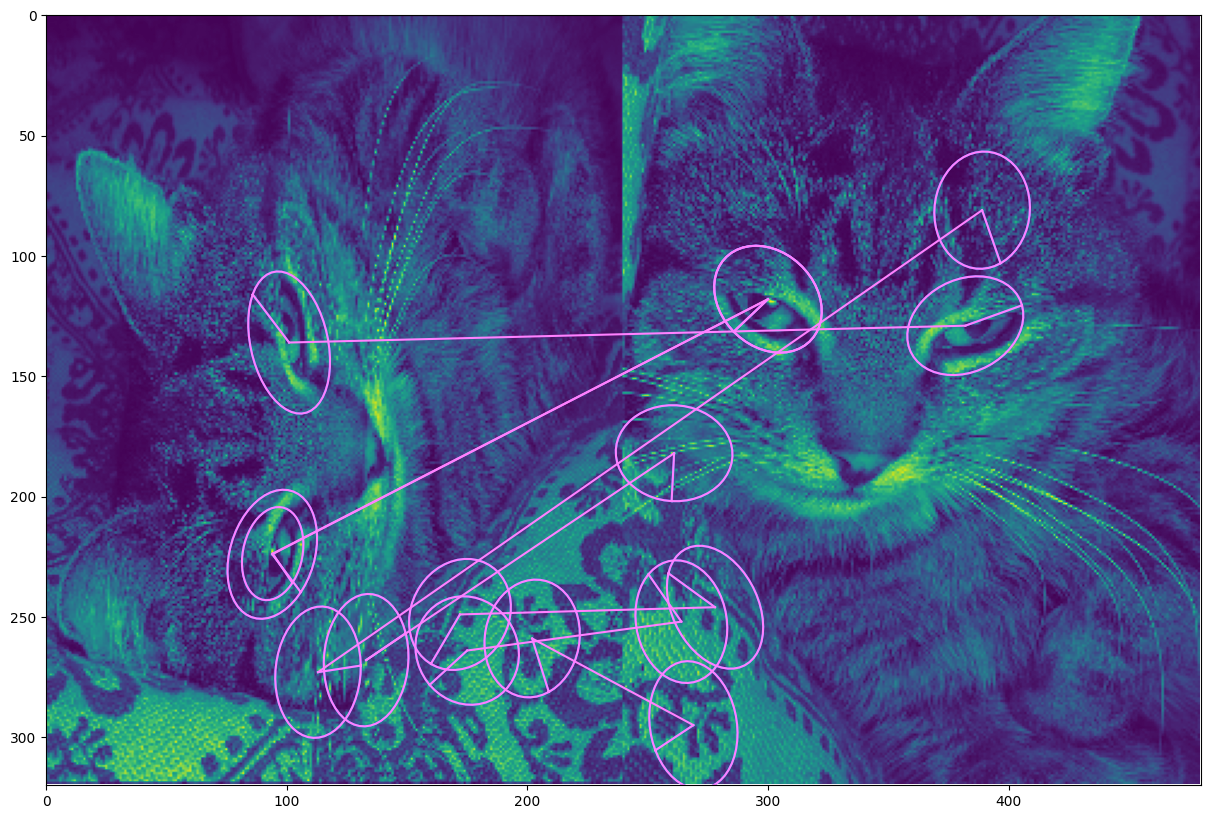

In [32]:
from kornia_moons.viz import draw_LAF_matches
n = out['keypoints1'].shape[0]
matching = torch.tensor([[i, i] for i in range(n)])
# Agora, desenhe os matchings
draw_LAF_matches(
    out['lafs0'],
    out['lafs1'],
    matching,
    K.tensor_to_image(img1_preprocessed.squeeze()),  # Garante que as imagens estão sem a dimensão de batch
    K.tensor_to_image(img2_preprocessed.squeeze()),
    None,  # Ou None se você não tiver uma máscara de inliers
    draw_dict={
        "inlier_color": (0.2, 1, 0.2),
        "tentative_color": (1.0, 0.5, 1),
        "feature_color": (0.2, 0.5, 1),
        "vertical": False,
    },
)

In [29]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import floyd_warshall
from scipy.spatial import Delaunay

INF = np.inf

# Calcula a distância Euclidiana entre dois pontos p1 e p2
def distancePoint(p1, p2):
    ax, ay = p1[0], p1[1]
    bx, by = p2[0], p2[1]
    dist = math.hypot(ax - bx, ay - by)
    return dist

# Aplica o algoritmo de Floyd-Warshall para encontrar as menores distâncias entre todos os pares de vértices
def floydWarshall(graph):
    graph = csr_matrix(graph)
    dist_matrix, predecessors = floyd_warshall(csgraph=graph, directed=False, return_predecessors=True)
    return dist_matrix

# Constrói a matriz de adjacência do grafo baseado em conexões entre pontos
def buildMapGraph(mapConex, mapPoint):
    size = len(mapPoint)
    sample = np.matrix(np.ones((size, size)) * np.inf)
    for i in range(size):
        sample[i, i] = 0  # Distância de um ponto para si mesmo é 0
    for conexao in mapConex:
        distance = distancePoint(mapPoint[conexao[0]], mapPoint[conexao[1]])
        sample[conexao[0], conexao[1]] = distance
    return sample

# Constrói conexões baseadas nos simplices da triangulação de Delaunay
def buildConnection(tri):
    mapConnection = []
    for simplice in tri.simplices:
        # Cada simplex representa um triângulo; adicione as arestas do triângulo ao grafo
        mapConnection.append([simplice[0], simplice[1]])
        mapConnection.append([simplice[1], simplice[2]])
        mapConnection.append([simplice[2], simplice[0]])
    return mapConnection

# Plota os pontos e a triangulação de Delaunay
def plot_delaunay(points, tri):
    plt.triplot(points[:, 0], points[:, 1], tri.simplices.copy())
    plt.plot(points[:, 0], points[:, 1], 'o')
    plt.show()

# Extrai o grafo a partir de um conjunto de pontos usando Delaunay, e calcula a matriz de distâncias usando Floyd-Warshall
def extract_graph(points):
    new_points = np.flip(points, axis=1)
    tri = Delaunay(new_points)
    mapConnection = buildConnection(tri)
    sample = buildMapGraph(mapConnection, new_points)
    graphCalc = floydWarshall(sample)
    return graphCalc, new_points, tri

# Compara duas matrizes de distância e conta os elementos cuja diferença é menor que um limiar
def match_matrix(mat_a, mat_b):
    mat_dist = mat_b - mat_a
    for i in range(mat_dist.shape[0]):
        mat_dist[i, :i] = 0  # Zera a metade inferior da matriz para evitar duplicação
    mat_dist = mat_dist * mat_dist  # Eleva as diferenças ao quadrado
    points = 0
    for i in range(mat_dist.shape[0]):
        for j in range(i + 1, mat_dist.shape[0]):
            if mat_dist[i, j] < 9:  # Limiar de similaridade
                points += 1
    return points

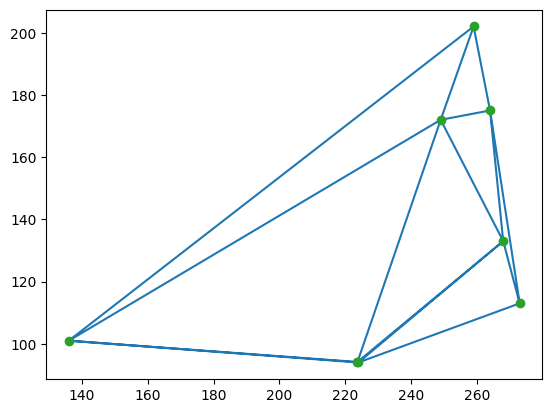

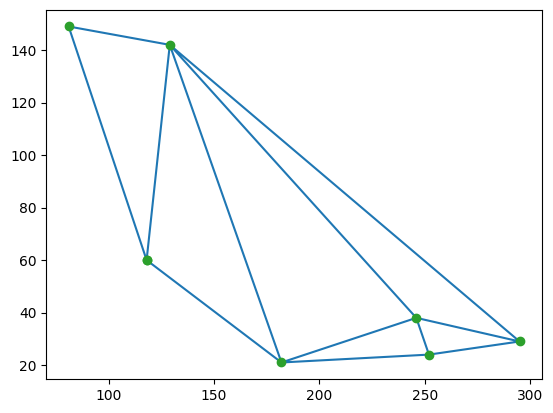

Matching Points: 1


In [33]:
pts0=out['keypoints0'].detach().numpy()
# Extrai o grafo, calcula as distâncias mínimas e obtém a triangulação de Delaunay
dist_matrix0, new_points0, tri0 = extract_graph(pts0)
# Plota a triangulação de Delaunay
plot_delaunay(new_points0, tri0)

pts1=out['keypoints1'].detach().numpy()
# Extrai o grafo, calcula as distâncias mínimas e obtém a triangulação de Delaunay
dist_matrix1, new_points1, tri1 = extract_graph(pts1)
# Plota a triangulação de Delaunay
plot_delaunay(new_points1, tri1)

# Compara as matrizes de distância dos dois grafos
matching_points = match_matrix(dist_matrix0, dist_matrix1)
print(f"Matching Points: {matching_points}")
